## Import libraries

In [ ]:
import sys
import os
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
from pathlib import Path
import random
import torch.nn.init as init
import numpy as np
# from keras.utils import np_utils

In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
np.set_printoptions(threshold=np.inf)

## Check GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

# torch and python versions ====================================================
print('torch.__version__:',torch.__version__)
print('sys.version:',sys.version)

Thu Mar  6 12:00:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8               5W /  78W |    658MiB /  6144MiB |     36%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Setting

In [ ]:
USE_ADAM = True
BATCH_SIZE_H1 = 32
BATCH_SIZE_H2 = 4
LEARNING_RATE_H1 = 0.001
LEARNING_RATE_H2 = 0.0008
HIDDEN_DIM = 128
N_LAYERS = 2
EPOCHS_H1 = 160
PATIENCE = 10
EPOCHS_H2 = 160
MIN_RANDOM_VALUES = 0
MAX_RANDOM_VALUES = 500
FORCE_TRAINING_H1 = False
FORCE_TRAINING_H2 = False
USE_VALIDATION = True
USE_EARLY_STOP = False
MODEL_NAME_H1 = 'model_H1.zip'
MODEL_NAME_H2 = 'model_H2.zip'

TEST_FRACTION = 0.4
VALIDATION_FRACTION = 0.1

## Prepare synthetic data

In [ ]:
# if Path(MODEL_NAME).is_file() and not FORCE_TRAINING:
binary_vectors = pd.read_csv('synthetic_data_10000.csv', index_col=0)
print(binary_vectors.shape)
binary_vectors = binary_vectors.to_numpy()
H1 = binary_vectors[2000]
H2 = binary_vectors[2001] + H1
binary_vectors = binary_vectors[:2000]
binary_vectors = binary_vectors.T
binary_vectors.shape

(2002, 10000)


(10000, 2000)

In [ ]:
print(binary_vectors.shape)
print(H1.shape)
print(H2.shape)

(10000, 2000)
(10000,)
(10000,)


## plot check

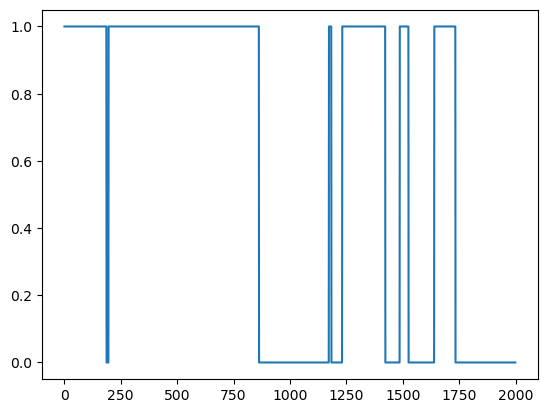

In [ ]:
import matplotlib.pyplot as plt
c=55
plt.plot(binary_vectors[c])
# fig = px.bar(binary_vectors[c])

In [ ]:
print(H1[c])
print(H2[c])

863.0
1232.0


## Expand dimension

In [ ]:
binary_vectors=np.expand_dims(binary_vectors, axis=2)
H1=np.expand_dims(H1, axis=1)
H2=np.expand_dims(H2, axis=1)

print(binary_vectors.shape)
print(H1.shape)
print(H2.shape)

(10000, 2000, 1)
(10000, 1)
(10000, 1)


## train & test split

In [ ]:
from sklearn.model_selection import train_test_split

num_samples = binary_vectors.shape[0]

# Split data into training set, validation set and test set ==============
validation_portion = int(VALIDATION_FRACTION*len(H1))
test_portion = int(TEST_FRACTION*len(H1))
validation_test_portion = validation_portion + test_portion

train_x = binary_vectors[:-validation_test_portion]
train_y_H1 = H1[:-validation_test_portion]
train_y_H2 = H2[:-validation_test_portion]

validation_x = binary_vectors[-validation_test_portion:-test_portion]
validation_y_H1 = H1[-validation_test_portion:-test_portion]
validation_y_H2 = H2[-validation_test_portion:-test_portion]

test_x = binary_vectors[-test_portion:]
test_y_H1 = H1[-test_portion:]
test_y_H2 = H2[-test_portion:]

In [ ]:
 # Create dataloaders =====================================================
train_data_H1 = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y_H1))
train_loader_H1 = DataLoader(train_data_H1, shuffle=False, batch_size=BATCH_SIZE_H1, drop_last=True)

validation_data_H1 = TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y_H1))
validation_loader_H1 = DataLoader(validation_data_H1, shuffle=False, batch_size=BATCH_SIZE_H1, drop_last=True)

train_data_H2 = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y_H2))
train_loader_H2 = DataLoader(train_data_H2, shuffle=False, batch_size=BATCH_SIZE_H2, drop_last=True)

validation_data_H2 = TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y_H2))
validation_loader_H2 = DataLoader(validation_data_H2, shuffle=False, batch_size=BATCH_SIZE_H2, drop_last=True)

## Prepare real data

In [ ]:
real = pd.read_csv('real_data.csv', header=None)

print(real.shape)

real = real.to_numpy()

print(real.shape)

X_real = real[:2000]
y_real = real[2000:]

y_real_H1 = y_real[0]
y_real_H2 = y_real[1]+y_real_H1

X_real = X_real.T
y_real_H1 = y_real_H1.T
y_real_H2 = y_real_H2.T

X_real = np.expand_dims(X_real, axis=2)
y_real_H1 = np.expand_dims(y_real_H1, axis=1)
y_real_H2 = np.expand_dims(y_real_H2, axis=1)
print(X_real.shape)
print(y_real_H1.shape)

(2002, 41)
(2002, 41)
(41, 2000, 1)
(41, 1)


## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.0):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.positive_variable = True

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)

        #self.bat_a = nn.BatchNorm1d(hidden_dim)
        #self.bat_b = nn.BatchNorm1d(hidden_dim)
        self.activation_a = nn.ReLU()
        #self.activation_b = nn.ReLU()
        self.fc_a = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc_b = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print('out.shape (before):',out.shape)

        '''
        The following statement is important: we are implementing a S2V model,
        so we select the latest output.
        '''

        out=out[:,-1]
        # print('out.shape (after):',out.shape)

        #out=self.activation_a(out)
        out=self.fc_a(out)
        out=self.activation_a(out)
        out=self.fc_b(out)

        if self.positive_variable:
          #out=torch.exp(out)
          #out=torch.abs(out)
          #out=torch.square(out)
          pass

        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [ ]:
def process_epoch(model, data_loader, criterion, optimizer, train):
    n_layers = model.n_layers
    hidden_dim = model.hidden_dim
    batch_size = data_loader.batch_size

    h = torch.zeros([n_layers, batch_size, hidden_dim]).to(device)

    total_loss = 0.
    counter = 0

    for x, y in data_loader:
        counter += 1

        h = torch.zeros([n_layers, batch_size, hidden_dim]).to(device)

        model.zero_grad()

        y_hat, h = model(x.to(device).float(), h)
        # print('Shape H:',h.shape)

        loss = criterion(y_hat, y.to(device).float())
        total_loss += loss.item()

        if train:
            loss.backward()
            optimizer.step()

        if counter%20==0:
            print("Step: {}/{}, Average Loss: {}".format(counter, len(data_loader), total_loss/counter))

    avg_loss = total_loss/len(data_loader)

    return avg_loss

def train(model_name, train_loader, validation_loader, learning_rate, batch_size, hidden_dim=64, n_layers=2, patience=None, epochs=None):
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1

    print('Input dim.:', input_dim)
    print('Output dim.:', output_dim)

    # The model
    model = Model(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    # criterion = nn.HuberLoss()
    if USE_ADAM:
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
      optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    model.train()

    epoch=1
    patience_counter = 0
    min_validation_loss=None
    validation_loss=None

    train_loss_list=[]
    validation_loss_list=[]

    # Training loop ============================================================
    while True:
        print("Epoch {}".format(epoch))

        print('Training...')
        train_loss = process_epoch(model, train_loader, criterion, optimizer, train = True)

        if USE_VALIDATION:
          print('Validation...')
          validation_loss = process_epoch(model, validation_loader, criterion, optimizer, train = False)
          validation_loss_list.append(validation_loss)

        train_loss_list.append(train_loss)

        if min_validation_loss is None or validation_loss<min_validation_loss or not USE_VALIDATION:
          # Save the model
          print('Saving the model...')
          torch.save(model, model_name)

          min_validation_loss = validation_loss
          patience_counter = 0
        else:
          print('Increasing patience counter')
          patience_counter +=1

        print("Epoch {} Completed, Train Loss: {}, Validation Loss: {}, Patience counter: {}".format(epoch, train_loss, validation_loss, patience_counter))

        if (patience_counter>patience and USE_EARLY_STOP) or epoch==epochs:
          break

        epoch += 1

    print('Restoring the best model...')
    model = torch.load(model_name)
    return model

In [ ]:
def evaluate(model, test_x, test_y):
    outputs = []
    targets = []

    for i in range(test_x.shape[0]):
        inp = torch.from_numpy(np.expand_dims(test_x[i], axis=0))

        out, h = model(inp.to(device).float(), None)

        outputs.append(out[0,0].item())
        targets.append(test_y[i])

        if i%5000==0:
          print(i,'/',test_x.shape[0],sep='')

    return outputs, targets

In [ ]:
def rmse(x,y):
  return np.sqrt(mean_squared_error(x,y))

def mae(x, y):
    return np.mean(np.abs(x - y))

# H1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if Path(MODEL_NAME_H1).is_file() and not FORCE_TRAINING_H1:
    # Load pre-trained model
    model_H1 = torch.load(MODEL_NAME_H1, map_location = device)
else:
    # Train a new model
    model_H1 = train(MODEL_NAME_H1, train_loader_H1, validation_loader_H1, batch_size=BATCH_SIZE_H1, learning_rate=LEARNING_RATE_H1, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, patience=PATIENCE, epochs=EPOCHS_H1)
    # Save the trained model
    torch.save(model_H1, MODEL_NAME_H1)

model_H1.to(device)

model_H1.eval()

Model(
  (gru): GRU(1, 128, num_layers=2, batch_first=True)
  (activation_a): ReLU()
  (fc_a): Linear(in_features=128, out_features=64, bias=True)
  (fc_b): Linear(in_features=64, out_features=1, bias=True)
)

## Synthetic data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_H1 = torch.load(MODEL_NAME_H1, map_location = device)

# Evaluation
predictions_array, targets_array = evaluate(model_H1, test_x, test_y_H1)

print('_'*80)

# R^2 ====================================================================
r2_prediction = r2_score(targets_array, predictions_array)
print('Prediction R²: {:.5f}'.format(r2_prediction))

print('_'*80)

## Real data

In [ ]:
# Evaluation
predictions_array, targets_array = evaluate(model_H1, X_real, y_real_H1)

print('_'*80)

# R^2 ====================================================================
r2_prediction = r2_score(targets_array, predictions_array)
print('Prediction R²: {:.5f}'.format(r2_prediction))

print('_'*80)

0/41
________________________________________________________________________________
Prediction R²: 0.97556
________________________________________________________________________________


# H2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if Path(MODEL_NAME_H2).is_file() and not FORCE_TRAINING_H2:
    # Load pre-trained model
    model_H2 = torch.load(MODEL_NAME_H2, map_location = device)
else:
    # Train a new model
    model_H2 = train(MODEL_NAME_H2, train_loader_H2, validation_loader_H2, batch_size=BATCH_SIZE_H2, learning_rate=LEARNING_RATE_H2, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, patience=PATIENCE, epochs=EPOCHS_H2)
    # Save the trained model
    torch.save(model_H2, MODEL_NAME_H2)

model_H2.to(device)

model_H2.eval()


Model(
  (gru): GRU(1, 128, num_layers=2, batch_first=True)
  (activation_a): ReLU()
  (fc_a): Linear(in_features=128, out_features=64, bias=True)
  (fc_b): Linear(in_features=64, out_features=1, bias=True)
)

## Synthetic data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_H2 = torch.load(MODEL_NAME_H2, map_location = device)

# Evaluation
predictions_array, targets_array = evaluate(model_H2, test_x, test_y_H2)

print('_'*80)

# R^2 ====================================================================
r2_prediction = r2_score(targets_array, predictions_array)
print('Prediction R²: {:.5f}'.format(r2_prediction))

print('_'*80)

## Real data

In [ ]:
# Evaluation
predictions_array, targets_array = evaluate(model_H2, X_real, y_real_H2)

print('_'*80)

# R^2 ====================================================================
r2_prediction = r2_score(targets_array, predictions_array)
print('Prediction R²: {:.5f}'.format(r2_prediction))

print('_'*80)

0/41
________________________________________________________________________________
Prediction R²: 0.82919
________________________________________________________________________________
